# Setup

In [1]:
# Plotting pretty figures and avoid blurry images
%config InlineBackend.figure_format = 'retina'  
# No need to include %matplotlib inline magic command. These things come built-in now.

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Enable multiple cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Import

In [6]:
import requests
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import transformers
from wordcloud import WordCloud,STOPWORDS
import nltk
import os

from sklearn import metrics
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig


# Download a kaggle dataset

In [7]:
train_url='https://www.kaggle.com/datasets/abhi8923shriv/sentiment-analysis-dataset?select=train.csv'
test_url='https://www.kaggle.com/datasets/abhi8923shriv/sentiment-analysis-dataset?select=test.csv'

In [8]:
train_save_path="/home/dah/nlp/sentiment_analysis/dataset/train.csv"
save_path="/home/dah/nlp/sentiment_analysis/dataset/"
path=os.listdir(save_path)
for x in path:
    if x.endswith('xls'):
        test_path=os.path.join(save_path,x)
print(test_path)
        

/home/dah/nlp/sentiment_analysis/dataset/test.xls


#### Loading data

In [9]:
train_data=pd.read_csv(train_save_path,encoding='ISO-8859-1')
#test_data=pd.read_excel(test_path)


### Analysing the data

In [10]:
train=train_data.copy()
#test=test_data.copy()
train.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [11]:
print(f" train.shape {train.shape}")


 train.shape (27481, 10)


In [27]:
# get the columns names
train.columns

Index(['textID', 'text', 'selected_text', 'sentiment', 'Time of Tweet',
       'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)',
       'Density (P/Km²)'],
      dtype='object')

In [28]:
#check differents type of sentiment
train['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [29]:
# Encodding the catagorical sentiment 'negative, positive and neutral' to numerical values
dataset=train[['text']]
labels=[]
for label in train['sentiment']:
    if label=='negative' : 
        labels.append(0)
    elif label=="neutral":
        labels.append(1)
    else :
        labels.append(2)
dataset['labels']=pd.DataFrame(labels)
    

In [30]:
dataset.head(10)

,text,labels
0,"I`d have responded, if I were going",1
1,Sooo SAD I will miss you here in San Diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",0
5,http://www.dothebouncy.com/smf - some shameles...,1
6,2am feedings for the baby are fun when he is a...,2
7,Soooo high,1
8,Both of you,1
9,Journey!? Wow... u just became cooler. hehe....,2


In [31]:
# Get the set of each type of sentiment
neutral_set=train[train['sentiment']=="neutral"]
negative_set=train[train['sentiment']=="negative"]
positive_set=train[train['sentiment']=="positive"]

In [32]:
#Create a list of stopword whix=ch will allow to remove stopwords in the dataset
stopwords = set(STOPWORDS)

In [33]:
 
# iterate through the csv file and generate a wordcloud
def wordcloud_generation(dataframe):
    
    comment_words = ''
    
    for index in dataframe.index:
         
        val=dataframe.loc[index,'text']
        val = str(val)
        tokens = val.split()
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
         
        comment_words += " ".join(tokens)+" "
     
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)
     
    # plot the WordCloud image                      
    plt.figure(figsize = (12, 6), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
     
    plt.show()

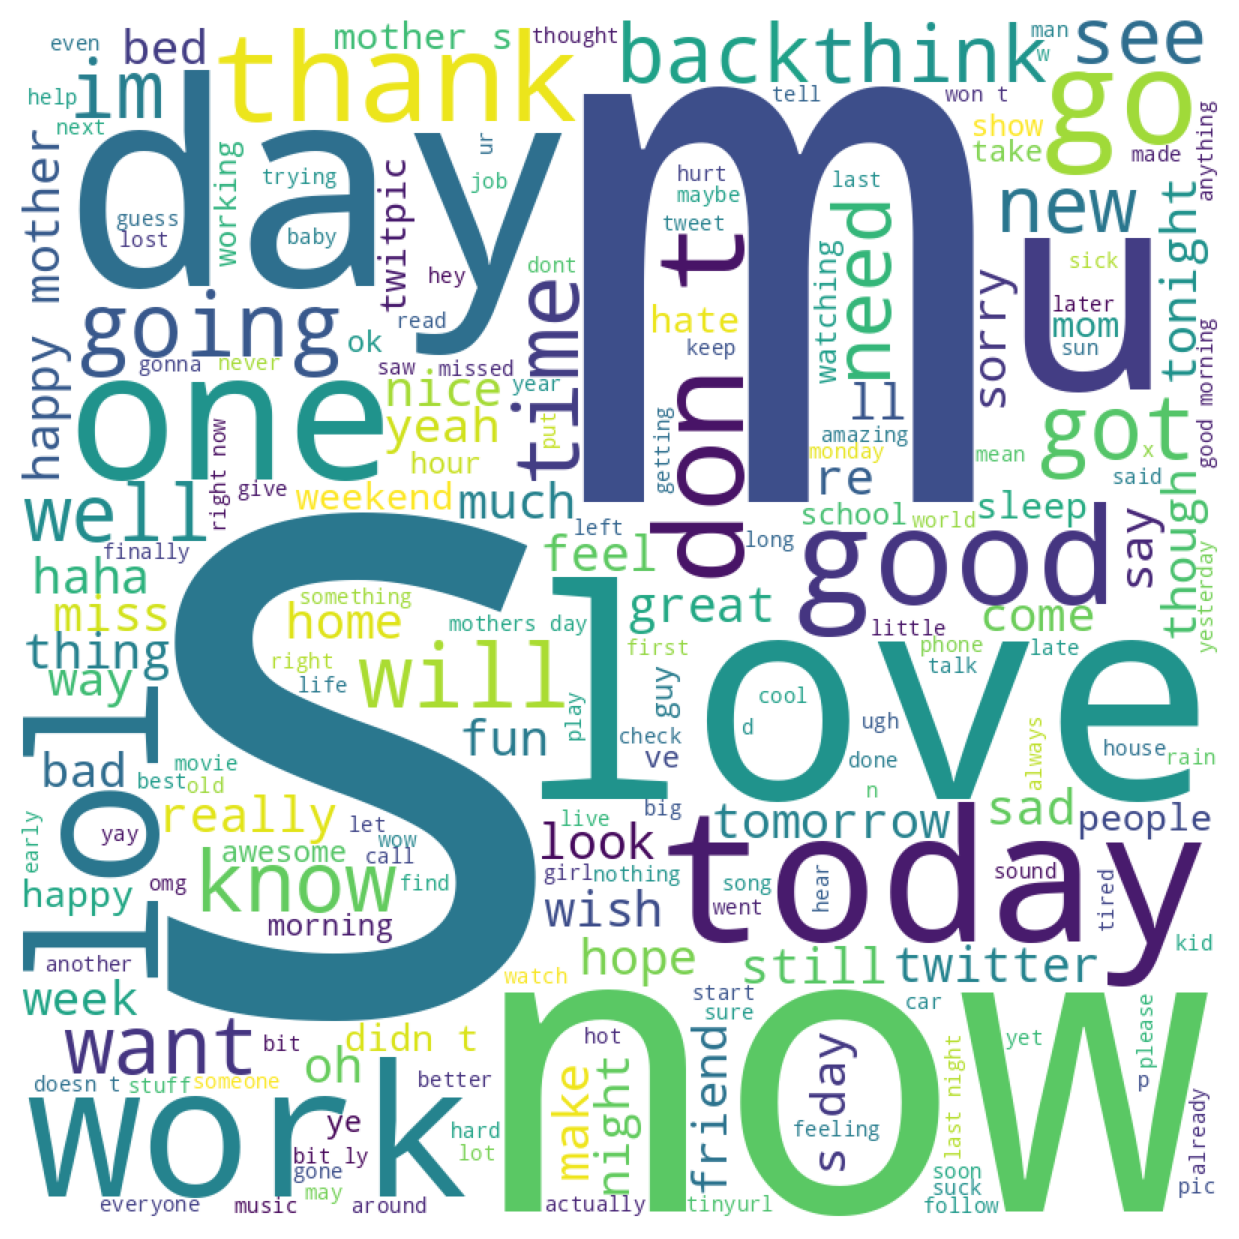

In [34]:
wordcloud_generation(train)

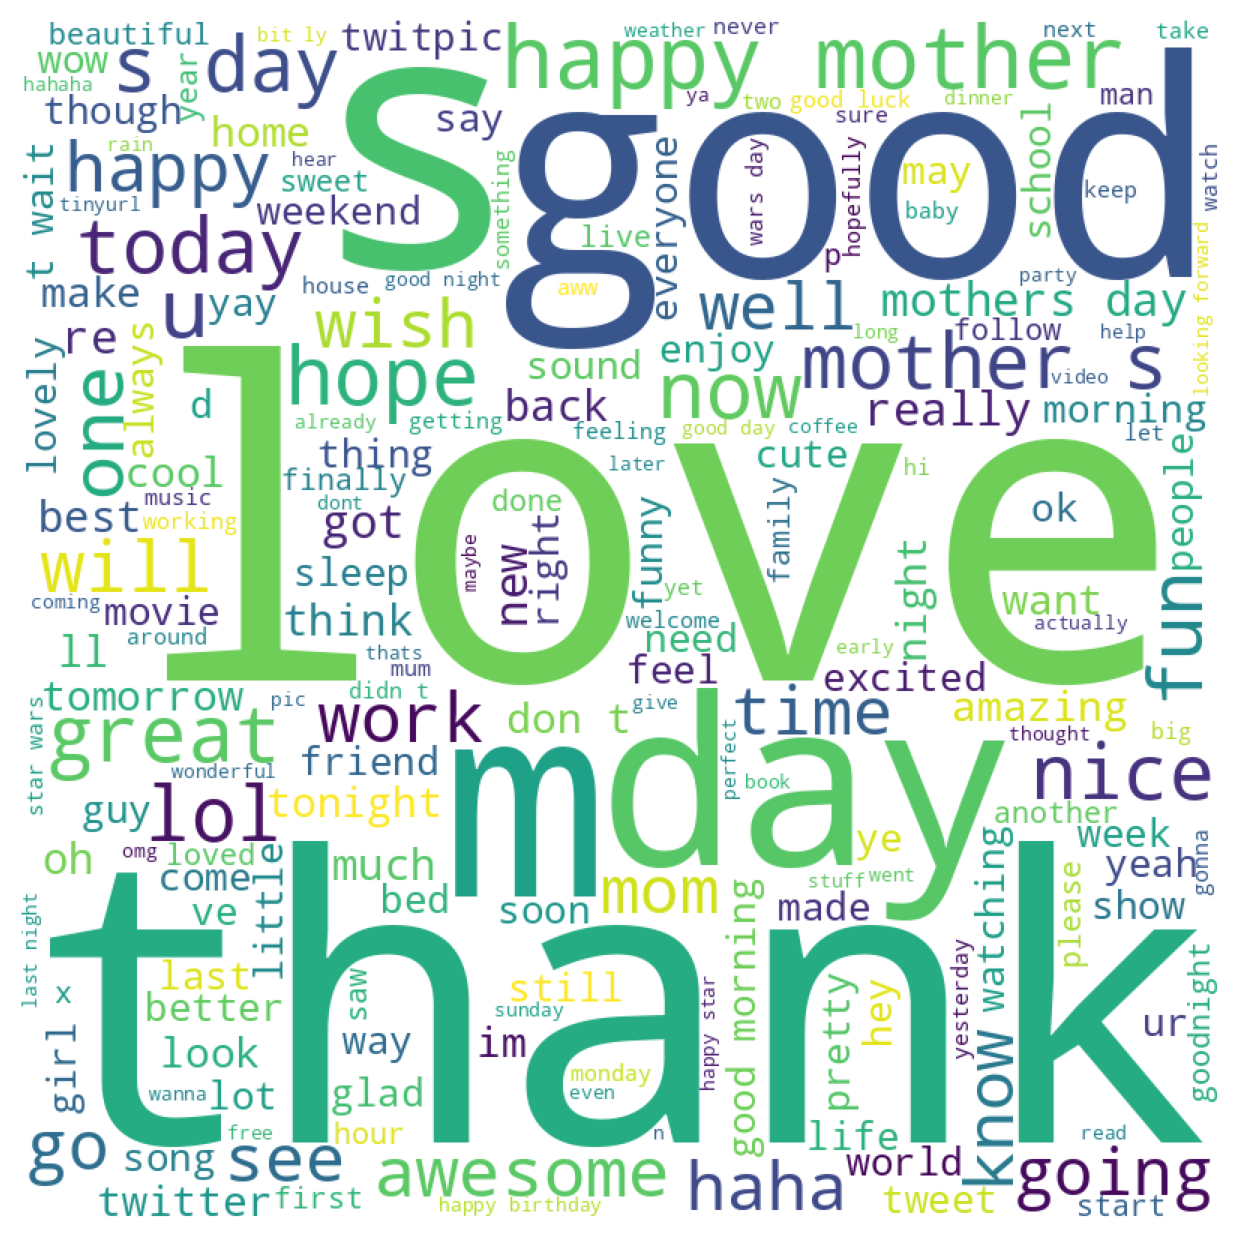

In [35]:
wordcloud_generation(positive_set)

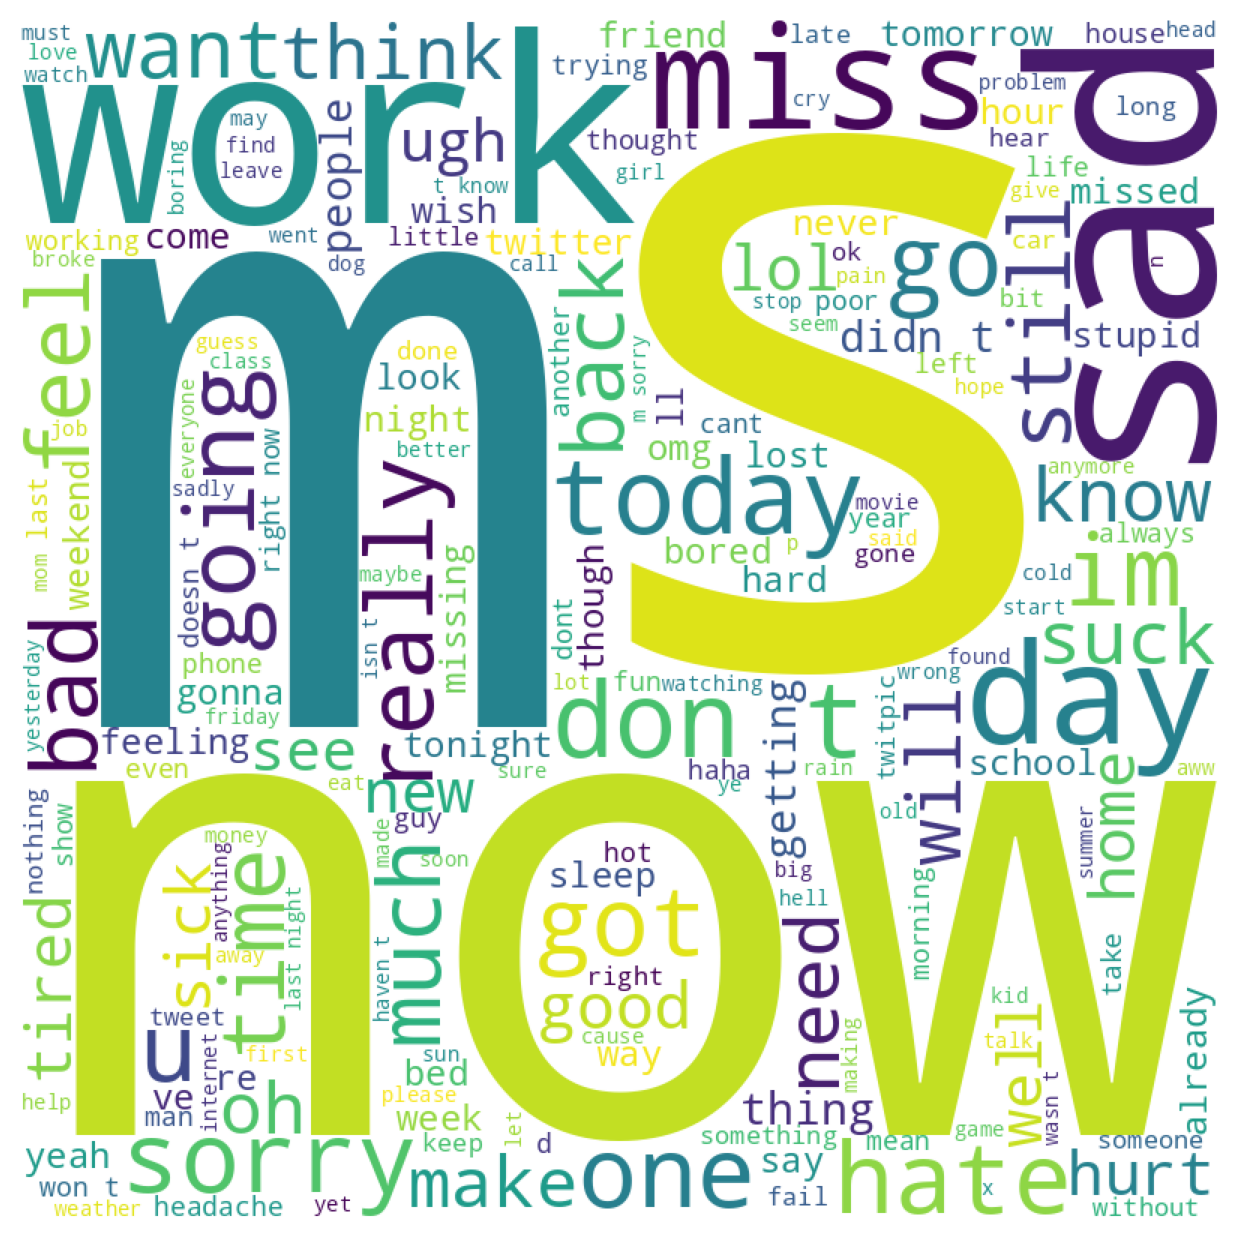

In [36]:
wordcloud_generation(negative_set)

<Axes: ylabel='proportion'>

<Axes: xlabel='sentiment'>

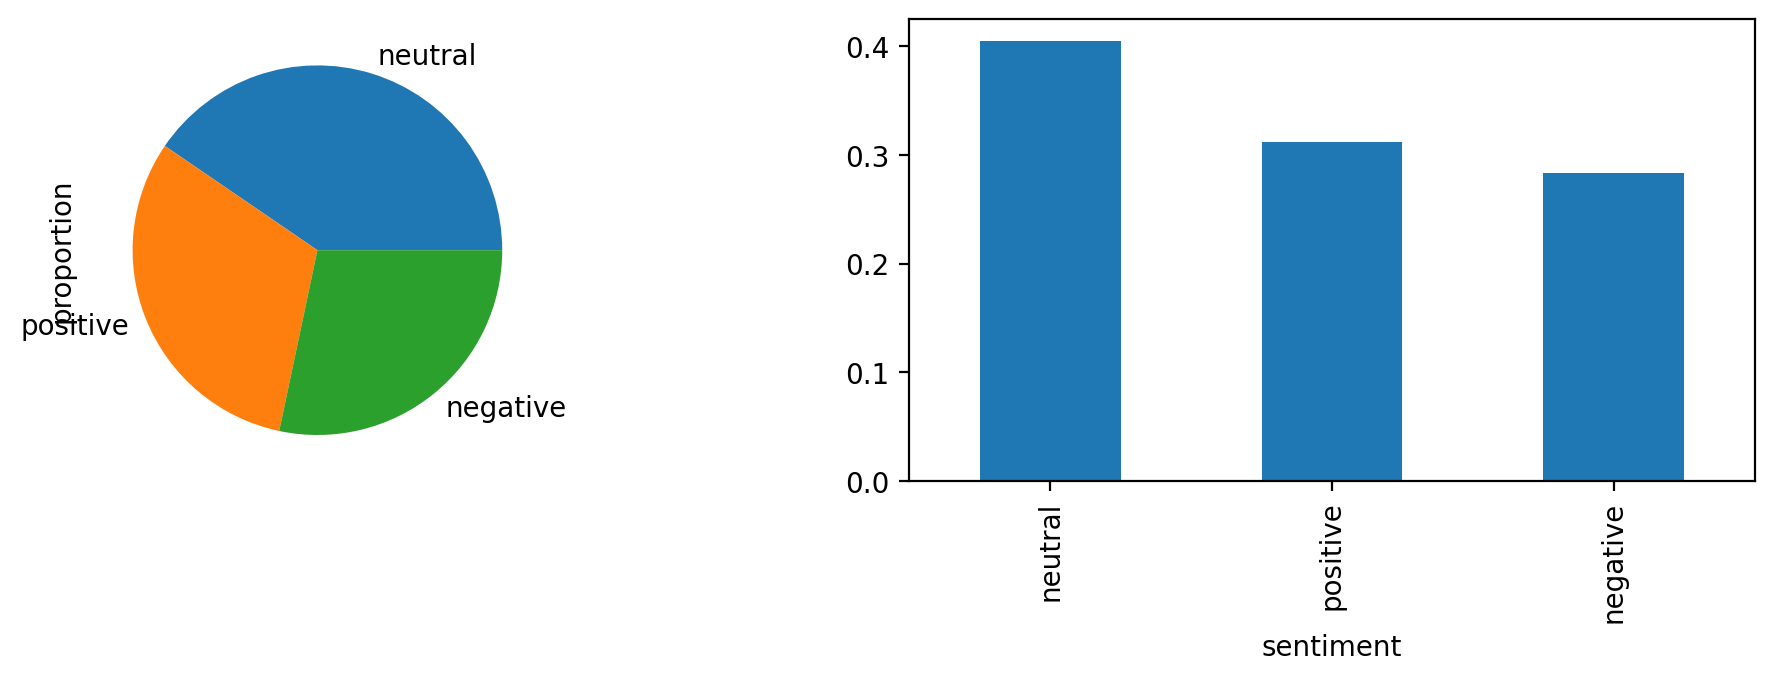

In [37]:
fig, ax=plt.subplots(1,2,figsize=(12,3))
train.sentiment.value_counts(normalize=True).plot(kind='pie',ax=ax[0])
train.sentiment.value_counts(normalize=True).plot(kind='bar',ax=ax[1])

plt.show()

# Device setting

In [38]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# HyperParameters

In [39]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 200
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
EPOCHS = 1
LEARNING_RATE = 1e-05
NUM_OF_CLASS=3
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Custom Dataset Building

In [40]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = dataframe.labels
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,#
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [41]:
#Creating the dataset and dataloader for the neural network

train_size = 0.8
train_dataset=dataset.sample(frac=train_size,random_state=42)
test_dataset=dataset.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(dataset.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (27481, 2)
TRAIN Dataset: (21985, 2)
TEST Dataset: (5496, 2)


In [46]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-uncased')
    self.drop = nn.Dropout(p=0.2)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
      
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

dtype('O')

In [ ]:
def train_epoch(model,
                data_loader,
                loss_fn,
                optimizer,
                device,
                scheduler,
                n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
          input_ids = d["input_ids"].to(device)
          attention_mask = d["attention_mask"].to(device)
          targets = d["targets"].to(device)
          outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
          )
          _, preds = torch.max(outputs, dim=1)
          loss = loss_fn(outputs, targets)
          correct_predictions += torch.sum(preds == targets)
          losses.append(loss.item())
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values
view raw
